# Computer Simulations - Project 1. @ ELTE
# N-body problem of satellite formation and clustering of planetary debris inside an asteroid belt

In [1]:
from platform import python_version

print(python_version())

3.6.0


In [2]:
#%%bash

#jupyter nbextension install --py mayavi --user # Install if missing
#jupyter nbextension enable mayavi --user --py

In [3]:
%%cmd

rem jupyter nbextension install --py mayavi --user # Install if missing
jupyter nbextension enable mayavi --user --py

Microsoft Windows [Version 10.0.18362.418]
(c) 2019 Microsoft Corporation. Minden jog fenntartva.

D:\GitHub\ELTE_Comp_Simulations_2020\Project 1\notebooks>
D:\GitHub\ELTE_Comp_Simulations_2020\Project 1\notebooks>rem jupyter nbextension install --py mayavi --user # Install if missing

D:\GitHub\ELTE_Comp_Simulations_2020\Project 1\notebooks>jupyter nbextension enable mayavi --user --py

D:\GitHub\ELTE_Comp_Simulations_2020\Project 1\notebooks>

Enabling notebook extension mayavi/x3d/x3dom...
      - Validating: ok


In [569]:
import os
import random
import numpy as np
from numba import jit
from datetime import datetime

from mayavi import mlab
from tvtk.api import tvtk
mlab.init_notebook()

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift, DBSCAN, KMeans

from IPython.display import clear_output, display

Notebook initialized with ipy backend.


## Configure matplotlib and seaborn parameters

In [5]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

In [6]:
# [Mass in kg |
#  Distance from central celestail body in AU |
#  eccentricity |
#  Size in AU]
Planets={
    'Sun': [1.989e30, 0, 0.0001, 4.649e-03],
    'Moon': [7.348e22, 0.00257, 0.0549, 1.161e-05],
    'Mercury': [3.285e23, 0.466697, 0.205630, 1.631e-05],
    'Venus': [4.867e24, 0.728213, 0.006772, 4.045e-05],
    'Earth': [5.972e24, 1.017, 0.0167086, 4.259e-05],
    'Mars': [6.39e23, 1.666, 0.0934, 2.266e-05],
    'Jupiter': [1.898e27, 5.4588, 0.0489, 4.673e-04],
    'Saturn': [5.683e26, 10.1238, 0.0565, 3.893e-04],
    'Uranus': [8.681e25, 20.11, 0.046381, 1.695e-04],
    'Neptune': [1.024e26, 30.33, 0.009456, 1.646e-04],
    'Pluto': [1.309e22, 49.305, 0.2488, 7.954e-06],
    'Halley': [2.2e14, 35.082, 0.96714, 3.68e-08]
}

Planet_Colors={
    'Sun': np.array([216, 148, 29])/255,
    'Moon': np.array([204, 198, 195])/255,
    'Mercury': np.array([186, 186, 186])/255,
    'Venus': np.array([216, 194, 153])/255,
    'Earth': np.array([45, 52, 130])/255,
    'Mars': np.array([217, 120, 62])/255,
    'Jupiter': np.array([187, 155, 99])/255,
    'Saturn': np.array([222, 181, 82])/255,
    'Uranus': np.array([201, 239, 241])/255,
    'Neptune': np.array([72, 120, 242])/255,
    'Pluto': np.array([65, 25, 20])/255,
    'Halley': np.array([0,0,0])/255
}

In [7]:
AU_to_km = 149597871                      # 1 AU = 149,597,871 km
y_to_h = 8760                             # 1 year = 8760 hours
GMPlusm = 4 * np.pi * np.pi               # Kepler's Third Law: G(M + m)/(4*pi^2) = 1 [AU^3/year^2]
G = 6.67408e-11                           # Gravitational constant [m^3 * kg^-1 * s^-1] 
G_km = G * 3600**2 / 1000**3              # Gravitational constant [km^3 * kg^-1 * hour^-2]
G_AU = G_km / AU_to_km**3 * y_to_h**2     # Gravitational constant [AU^3 * kg^-1 * year^-2]
c_lgh = 299792.458                        # Speed of light [km/s]
c_AU = c_lgh / AU_to_km * 3600 * y_to_h   # Speed of light [AU/year]

## Transfer function

In [8]:
def transfer_function(t, cutoff):
    
    scale = 60
    r = np.zeros(len(t))
    norm = 1 / np.e**(-1/scale*np.abs(cutoff))
    for i, k in enumerate(t):
        if np.abs(k) < cutoff:
            r[i] = 1
        else:
            r[i] = norm * np.e**(-1/scale*np.abs(k))
    return r

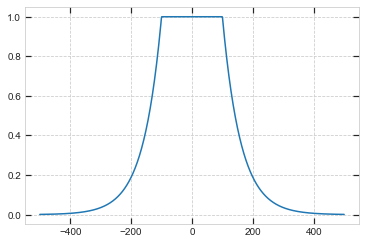

In [9]:
func = np.linspace(-500,500,999)

plt.plot(func, transfer_function(func, cutoff=100))

plt.show()

## Generating mass and size of small bodies

#### Sourced from
- Krasinsky, G.A. & Pitjev, N. & Vasilyev, Mikhail & Yagudina, Eleonora. (2002). Hidden Mass in the Asteroid Belt. Icarus. 158. 98-105. 10.1006/icar.2002.6837. doi:[10.1006/icar.2002.6837](https://doi.org/10.1006/icar.2002.6837)

For C, S and M types:
$$
\overline{\rho_{C}} = 1.38 \frac{\text{g}}{\text{cm}^{3}} = 1380 \frac{\text{kg}}{\text{m}^{3}}
$$

$$
\overline{\rho_{S}} = 2.27 \frac{\text{g}}{\text{cm}^{3}} = 2270 \frac{\text{kg}}{\text{m}^{3}}
$$

$$
\overline{\rho_{T}} = 5.32 \frac{\text{g}}{\text{cm}^{3}} = 5320 \frac{\text{kg}}{\text{m}^{3}}
$$

In [613]:
# Number of small bodies around the central object
n_bodies = int(1e02)

# Select whether the objects' motion in the asteroid belt
# would be prograde or retrograde. In this case, prograde
# will mean counterclockwise, and retrograde will mean
# clockwise motion of the asteroid belt.
prograde = True

# Select central object
planet = 'Jupiter'

In [614]:
# In kg/m^3
rho_C = 1380
rho_S = 2270
rho_T = 5320

In [615]:
def gen_geom(planet='Jupuiter', n_bodies=1e02):

    geometries = np.zeros((n_bodies+1, 2))
    
    # Range of radius values for small bodies
    # Radius in meters
    lowest_R = 5000
    highest_R = 50000

    # Add data of the central planet into the geometries list
    # [0,0] = M [kg]
    # [0,1] = R [km]
    geometries[0,0] = Planets[planet][0]
    geometries[0,1] = Planets[planet][3] * AU_to_km

    # Calculate geometric parameters of the small objects
    # [i,0] = m [kg]
    # [i,1] = r [km]
    for i in range(n_bodies):

        radius = np.random.randint(low=lowest_R, high=highest_R)
        volume = 4/3 * radius**3 * np.pi
        mass = volume * rho_S

        geometries[i+1,0] = mass
        geometries[i+1,1] = radius / 1000
        
    return geometries

## Generating coordinates of small bodies

In [617]:
def sign_choose():
    return -1 if random.random() < 0.5 else 1

In [697]:
def gen_coord_and_vel(planet='Jupiter', n_bodies=1e02, obliquity=0.5):
    coordinates = np.zeros((n_bodies+1, 2))
    velocities = np.zeros((n_bodies+1, 2))

    R = Planets[planet][3] * AU_to_km
    dr = 1.5
    r = 10
    max_e = 0.4

    # Focal distance of trajectories
    # This is basically the central object's coordinates
    c = obliquity * R

    # Add data of the central planet into the coordinates and
    # velocities list
    coordinates[0,:] = np.array((c,0))
    velocities[0,:] = np.array((0,0))

    # Generating bodies' coordinates in 2D
    # The points should be situated on the surface of
    # an ellipse, which axes' length sould be: a,b
    for i in range(n_bodies):
        # Semi-major and semi-minor axes
        # Generating length of the perigees and eccentricities
        # and calculating semi-major axis lengths using these
        # r_p = a * (1 - e^2) --> a = r_p / (1 - e^2)
        r_p = (R + 1) * r + R * np.random.rand() * dr
        e = np.random.random() * max_e
        a = r_p / (1 - e**2)
        # Calculating semi-minor axis length and eccentricity
        # c = sqrt(a^2 - b^2) |
        # e = c/a             | 
        # --> e = sqrt(1 - (b/a)^2)
        # --> b = +- sqrt(a^2 * (1 - e^2))
        b = r_p / np.sqrt(1 - e**2)

        # Generating angle parameters to get coordinates of objects
        # phi   : [0°,360°]
        # theta : [0°,180°]
        phi = (np.random.randint(360) + np.random.random()) / 180 * np.pi
        # we choose an upper limit for theta
        #theta_max = 10
        #theta = (np.random.randint(theta_max) * sign_choose() + 89 + np.random.random()) / 180 * np.pi

        x_coord = a * np.cos(phi)
        y_coord = b * np.sin(phi)
        #x_coord = a * np.sin(theta) * np.cos(phi)
        #y_coord = b * np.sin(theta) * np.sin(phi)
        #z_coord = a * np.cos(theta)

        # Norm back to AU
        x_coord /= AU_to_km
        y_coord /= AU_to_km
        #z_coord /= AU_to_km

        # |v| = sqrt(GM * (2/d - 1/a))
        # [v] = sqrt(AU^3 * kg^-1 * year^-2 * kg * AU^-1) =
        #     = sqrt(AU^2 * year^-2) =
        #     = AU/year
        # 1. Calculate real length of velocity vectors for the
        #    Vis-Viva equation
        d = np.sqrt((x_coord-c/AU_to_km)**2 + y_coord**2)# + z_coord**2)
        v = np.sqrt(G_AU * Planets[planet][0] * (2/d - 1/(a/AU_to_km)))

        # 2. Calculate the velocity vectors   
        v_e_x = -a * np.sin(phi) / d
        v_e_y = b * np.cos(phi) / d

        v_x = v_e_x * v
        v_y = v_e_y * v

        # Save coordinates and velocities
        # [r] = km
        # [v] = km/hour
        coordinates[i+1,0] = x_coord * AU_to_km
        coordinates[i+1,1] = y_coord * AU_to_km
        #coordinates[i+1,2] = z_coord * AU_to_km
        velocities[i+1,0] = v_x / y_to_h
        velocities[i+1,1] = v_y / y_to_h
        #velocities[i+1,2] = v_z * AU_to_km / y_to_h

    return coordinates, velocities

In [698]:
geometries = gen_geom(planet=planet, n_bodies=n_bodies)

In [699]:
coordinates, velocities = gen_coord_and_vel(planet=planet, n_bodies=n_bodies, obliquity=1)

### Plot initial conditions

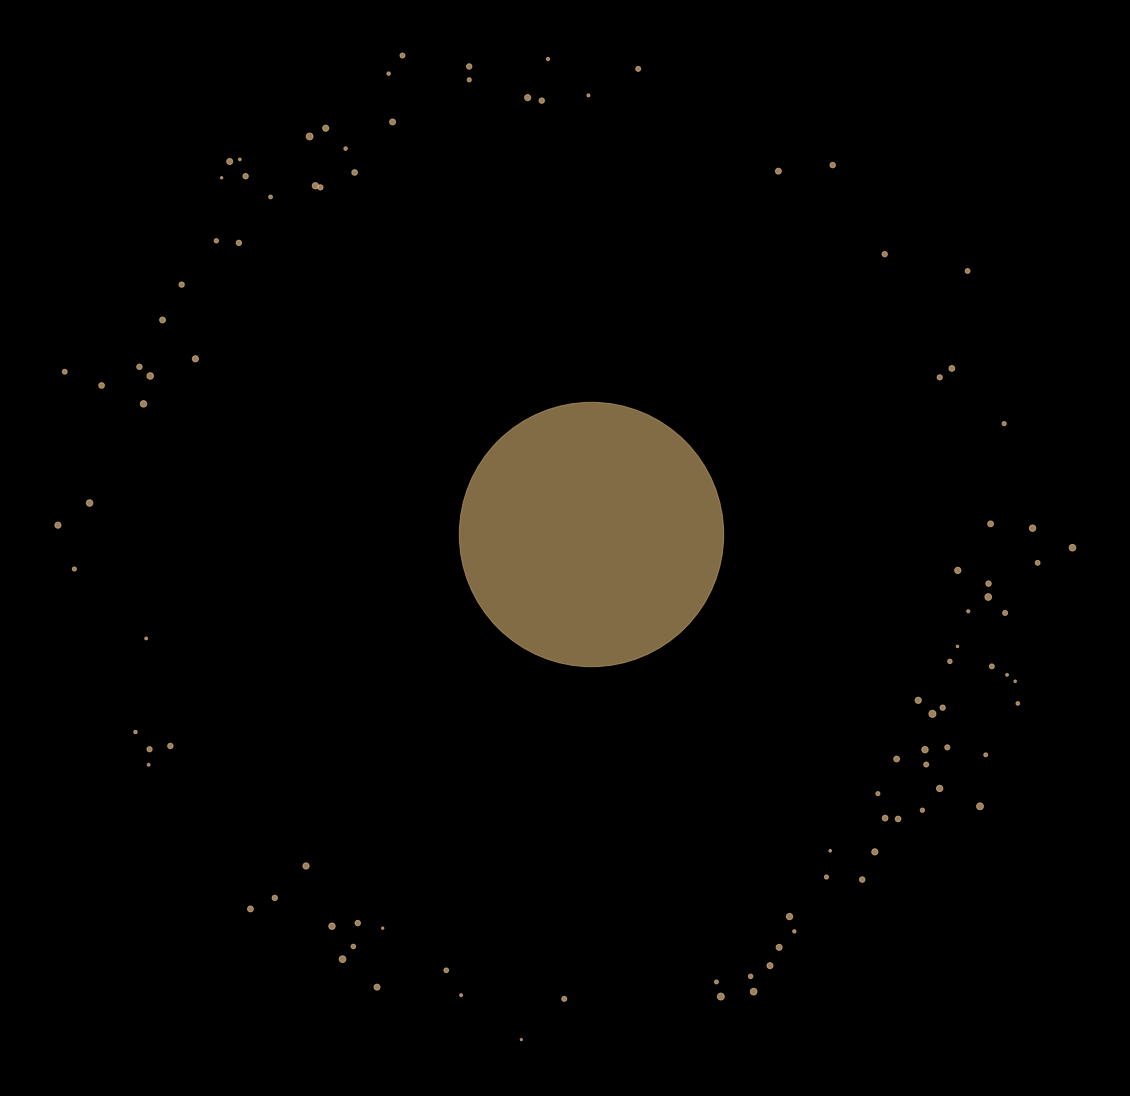

In [700]:
fig, axes = plt.subplots(figsize=(20, b/a*20), facecolor='black')
axes.set_facecolor('black')
axes.axis('off')

# burlywood
# silver
axes.scatter(coordinates[1:,0], coordinates[1:,1],
             color='burlywood', s=geometries[1:,1], alpha=0.7)
axes.scatter(coordinates[0,0], coordinates[0,1],
             color=Planet_Colors[planet], s=geometries[0,1], alpha=0.7)

#Planet_Pch = Circle(xy=(c,0), radius=R,
#                    ec=Planet_Colors[planet], fc=Planet_Colors[planet])
#axes.add_patch(Planet_Pch)

axes.set_xticks([])
axes.set_yticks([])

plt.show()

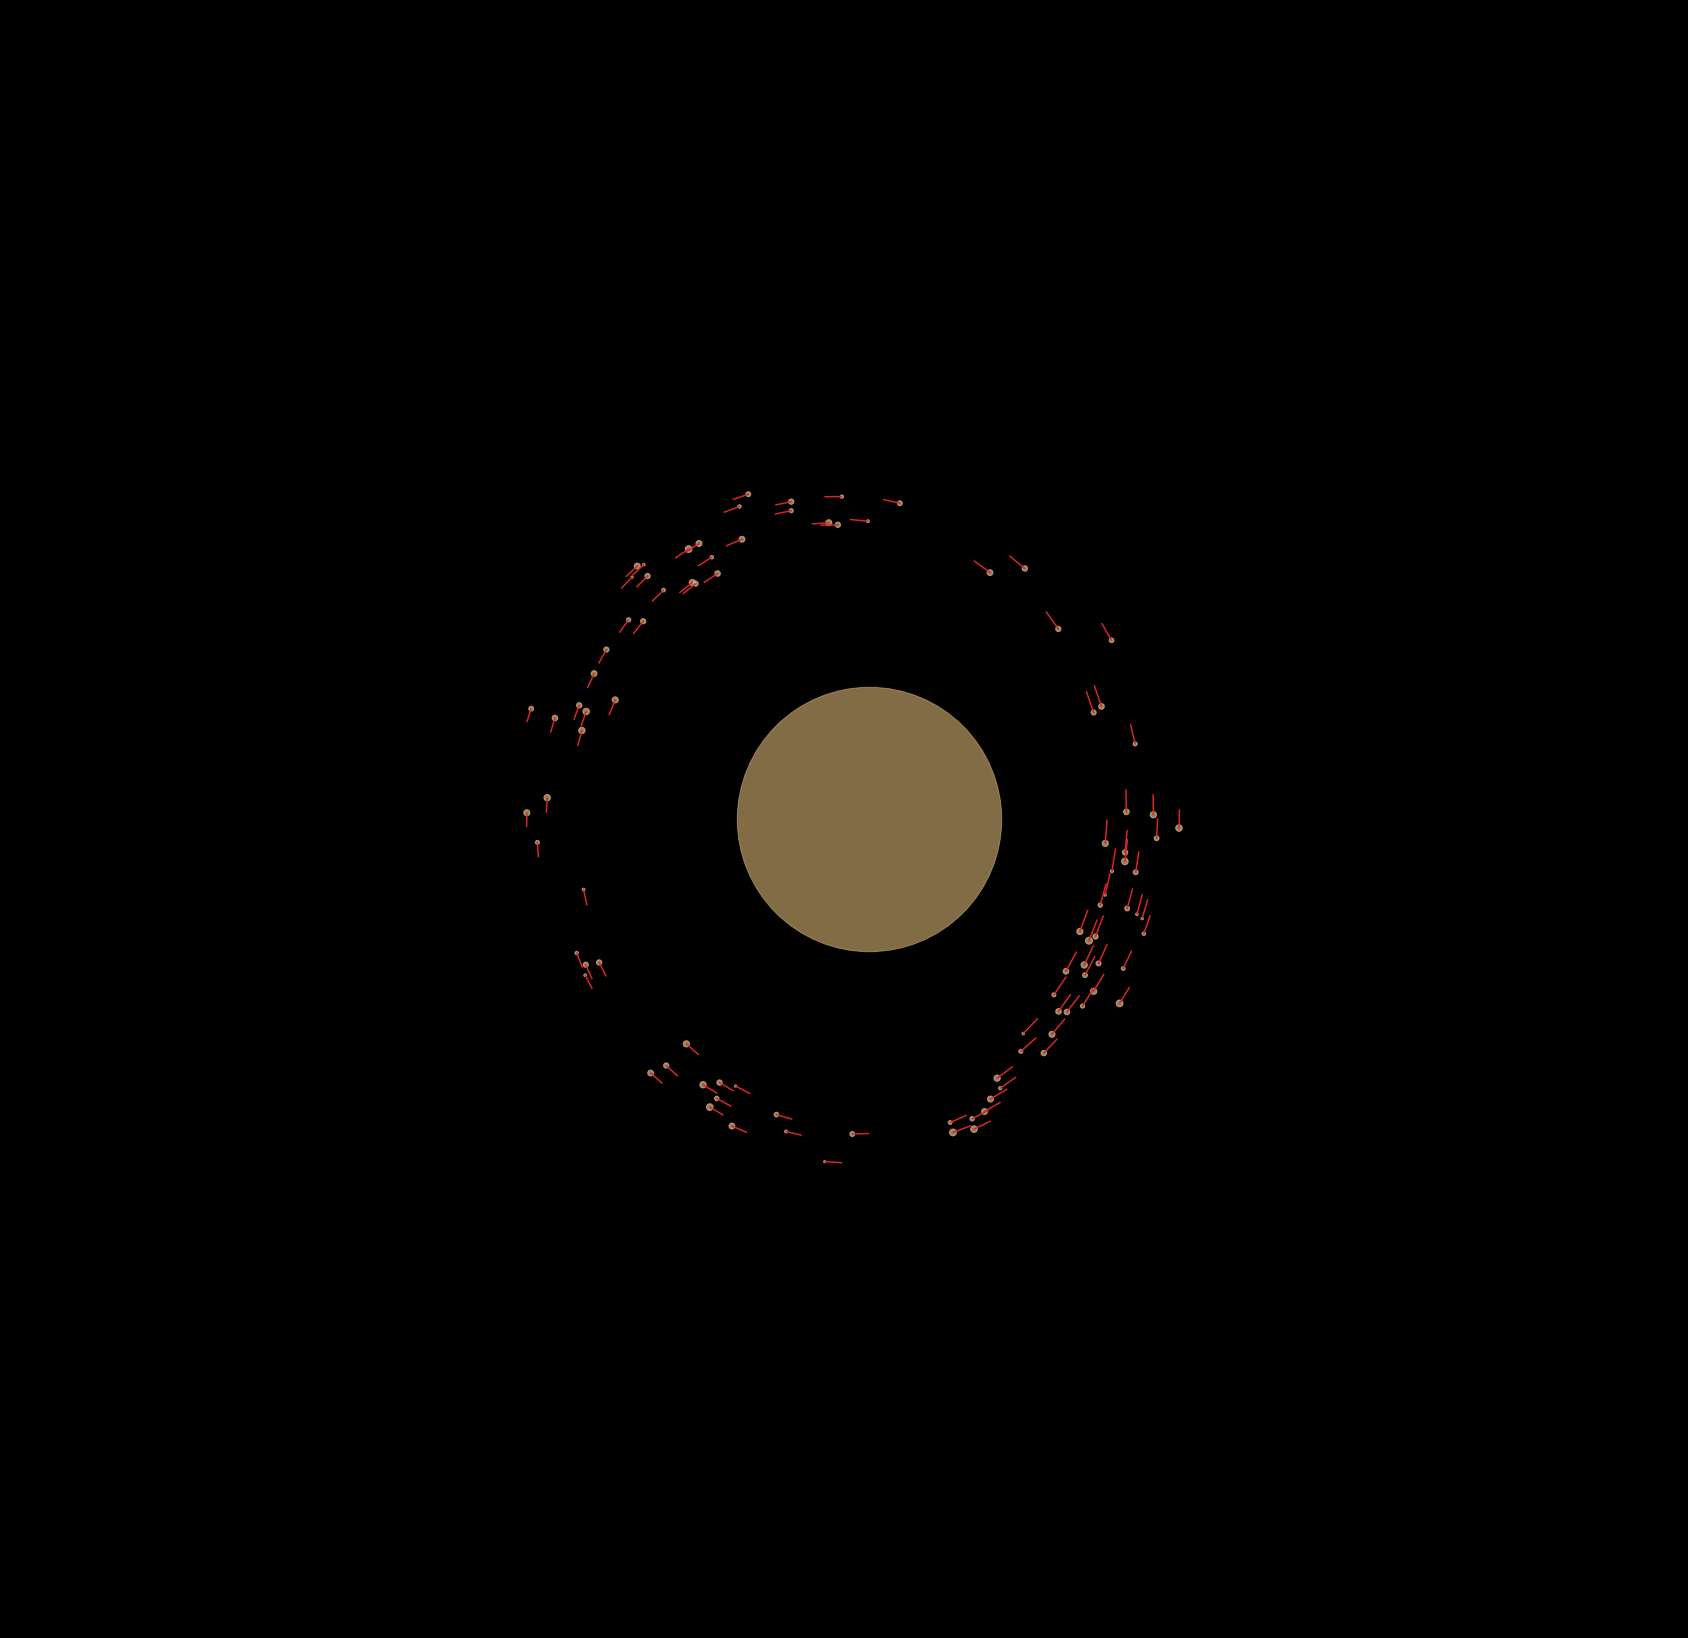

In [701]:
fig, axes = plt.subplots(figsize=(30, b/a*30), facecolor='black')
axes.set_facecolor('black')
axes.axis('off')

# burlywood
# silver
vel_scale = 1
for idx, v in enumerate(velocities):
    axes.plot([coordinates[idx,0], coordinates[idx,0]+vel_scale*v[0]],
              [coordinates[idx,1], coordinates[idx,1]+vel_scale*v[1]],
              color='tab:red')
axes.scatter(coordinates[1:,0], coordinates[1:,1],
             color='burlywood', s=geometries[1:,1], alpha=0.7)
axes.scatter(coordinates[0,0], coordinates[0,1],
             color=Planet_Colors[planet], s=geometries[0,1], alpha=0.7)

scale = 2.5
axes.set_xlim(-np.max(coordinates[:,0])*scale, np.max(coordinates[:,0])*scale)
axes.set_ylim(-np.max(coordinates[:,1])*scale, np.max(coordinates[:,1])*scale)

axes.set_xticks([])
axes.set_yticks([])

plt.show()

## 3D plot

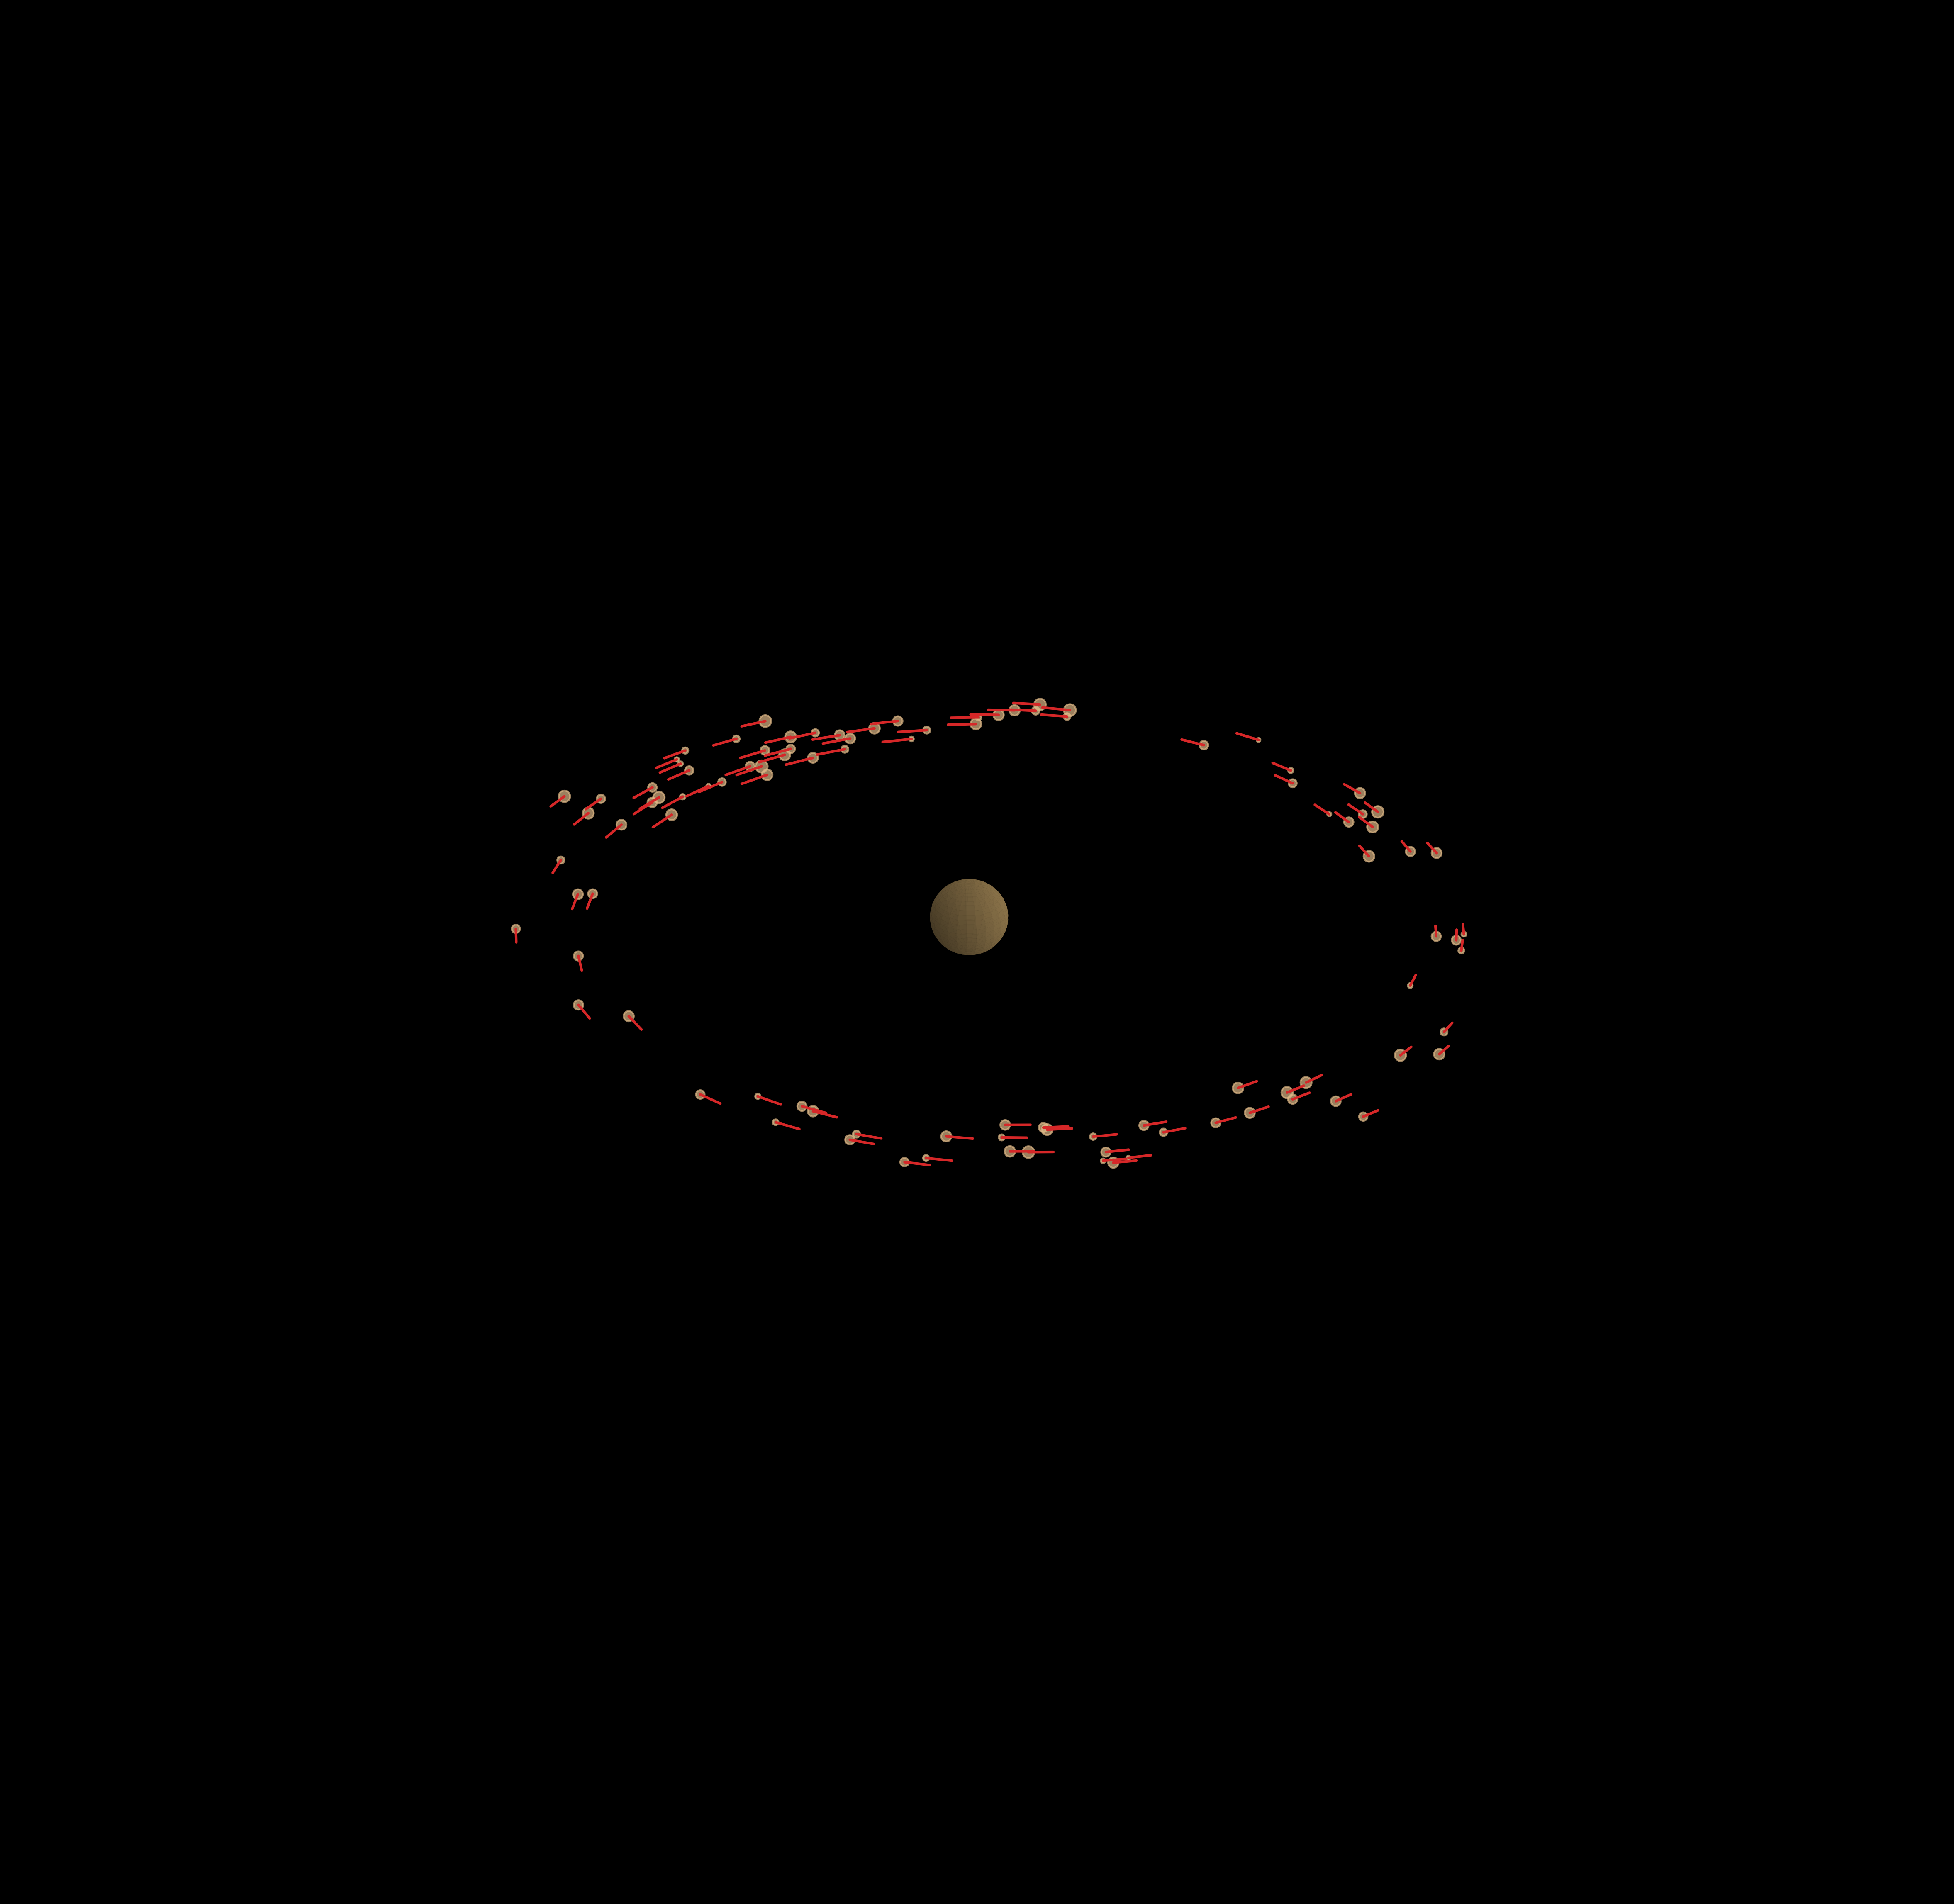

In [702]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300, facecolor='black', subplot_kw={'projection' : '3d'})
#ax.set_aspect('equal')

azimuth = 120
elevation = 30
ax.view_init(elevation, azimuth)
ax.set_facecolor('black')
ax.axis('off')

scale = 1.2
ax.set_xlim3d(-a*scale, a*scale)
ax.set_ylim3d(-a*scale, a*scale)
ax.set_zlim3d(-a*scale, a*scale)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Plot planet
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = R * np.outer(np.cos(u), np.sin(v))
y = R * np.outer(np.sin(u), np.sin(v))
z = R * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x+c, y, z, rstride=4, cstride=4, color=Planet_Colors[planet], linewidth=0, alpha=0.5)

vel_scale = 1
for idx, v in enumerate(velocities):
    ax.plot([coordinates[idx,0], coordinates[idx,0]+vel_scale*v[0]],
            [coordinates[idx,1], coordinates[idx,1]+vel_scale*v[1]],
            color='tab:red')
ax.scatter(coordinates[1:,0], coordinates[1:,1],
            edgecolor=None, color='burlywood', s=geometries[1:,1], alpha=0.7)

plt.show()

## RK4

In [703]:
@jit(nopython=True)
def sum_j(X, i):

    # Gravitational acceleration
    # --------------------------
    # a_i = - G * sum_j {m_j * (r_i - r_j) / |r_i - r_j|^3}
    # summ = sum_j {m_j * (r_i - r_j) / |r_i - r_j|^3}
    summ = np.zeros(len(X))
    for j in range(0, len(new_coordinates)):
        if i != j:
            # Calculate the d = |r_i - r_j| part
            r_dist = np.linalg.norm(X - new_coordinates[j,:])
            if (r_dist > geometries[i,1] + geometries[j,1]) and (r_dist < 2*R or j == 0):
                # Calculate the d^3 part
                r_cubed = r_dist*r_dist*r_dist
                summ += geometries[j, 0] * (X - new_coordinates[j,:]) / r_cubed

    return summ

In [629]:
@jit(nopython=True)
def derivates(X, V, i):
    assert X.size == V.size
    # Create placeholder array to store output of the RK4 step
    # f = [t, r_x, r_y, r_z, v_x, v_y, v_z]
    dXdt = np.zeros(len(X))
    dVdt = np.zeros(len(V))

    # Calculate derivates for RK4
    # ---------------------------
    # d(t)/dt = 1
    #
    # d(r_x)/dt = v_x
    # d(r_y)/dt = v_y
    # etc...
    #
    # d(v_x) = a_x
    # d(v_y)/dt = a_y
    # etc...
    # where : a_i = - G * sum_j {m_j * (r_i - r_j) / |r_i - r_j|^3}
    dXdt = V
    dVdt = - G * sum_j(X, i)

    return dXdt, dVdt

In [630]:
@jit(nopython=True)
def RK4_step(i, dt):
    X = new_coordinates[i]
    V = new_velocities[i]
    k1X, k1V = derivates(X, V, i)
    k1X = k1X * dt
    k1V = k1V * dt
    
    k2X, k2V = derivates(X + 0.5 * k1X, V + 0.5 * k1V, i)
    k2X = k2X * dt
    k2V = k2V * dt
    
    k3X, k3V = derivates(X + 0.5 * k2X, V + 0.5 * k2V, i)
    k3X = k3X * dt
    k3V = k3V * dt
    
    k4X, k4V = derivates(X + k3X, V + k3V, i) 
    k4X = k4X * dt
    k4V = k4V * dt

    dX = (k1X + 2 * k2X + 2 * k3X + k4X) / 6.0
    dV = (k1V + 2 * k2V + 2 * k3V + k4V) / 6.0

    return dX, dV

In [663]:
def step_t(new_coordinates, new_velocities, max_t=1, dt=5e-3):

    t = 0
    while t <= max_t:
        for i in range(len(new_coordinates)):
            dX, dV = RK4_step(i=i, dt=dt)
            new_coordinates[i] += dX
            new_velocities[i] += dV

        if (t//dt % 20 == 0) or (int(t/dt+1)==int(max_t/dt)):
            clear_output(wait=True)
            print('\rt : {0:.0f}/{1:.0f}'.format(t/dt+1, max_t/dt))

        t += dt
        
    return new_coordinates, new_velocities

In [687]:
new_coordinates = coordinates.copy()
new_velocities = velocities.copy()

In [688]:
# dt : [Years]
dt=5e-3
# max_t : [Years]
max_t=10

start = datetime.now()
step_t(new_coordinates, new_velocities,
       max_t=max_t, dt=dt)
end = datetime.now()
#np.save('coords', new_coordinates)
#np.save('vels', new_velocities)

t : 2000/2000


In [689]:
print('Total time was needed :', end-start)

Total time was needed : 0:00:37.752447


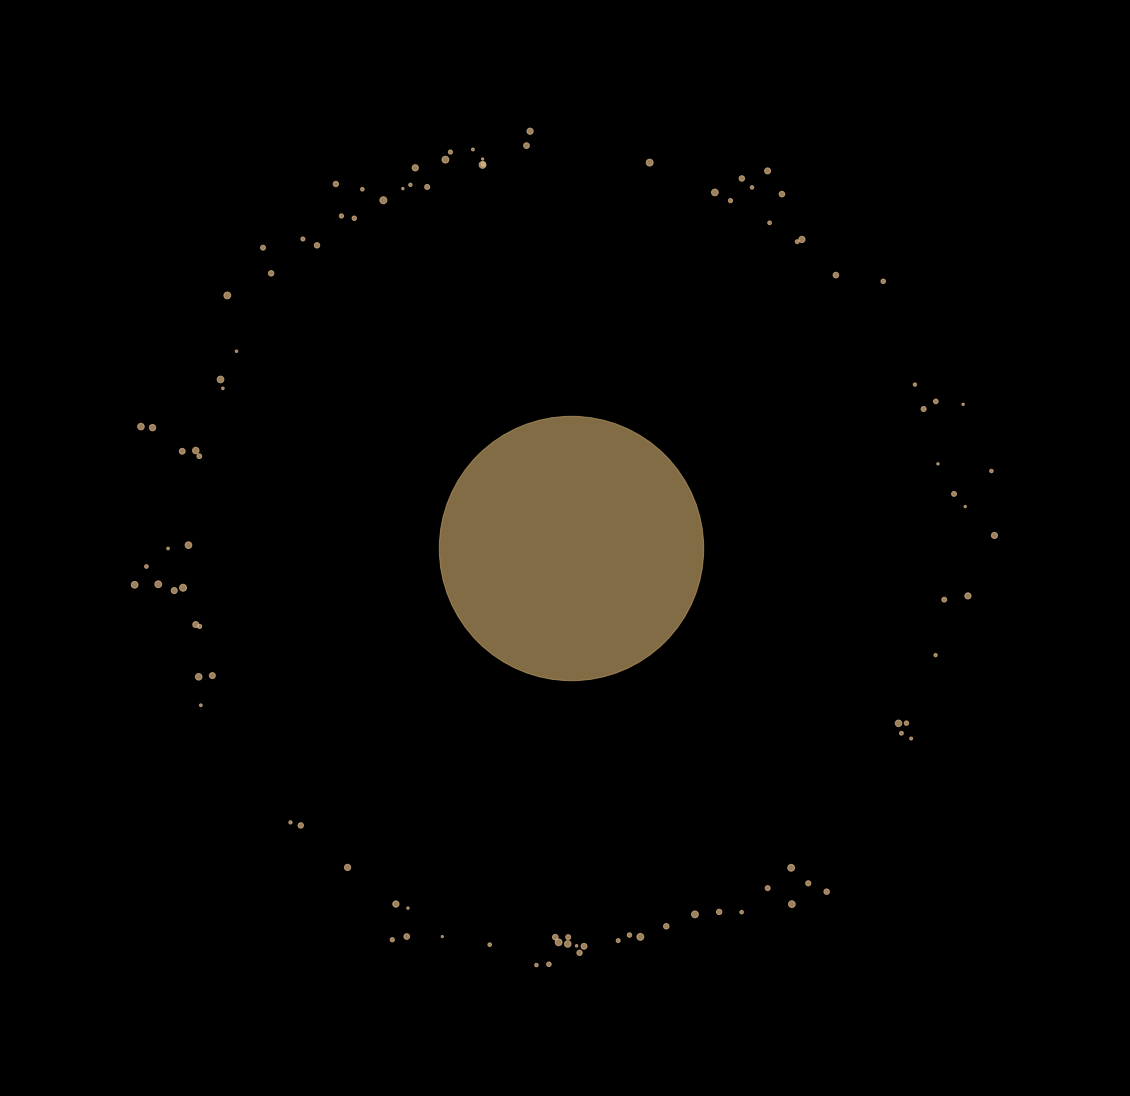

In [690]:
fig, axes = plt.subplots(figsize=(20, b/a*20), facecolor='black')
axes.set_facecolor('black')
axes.axis('off')

# burlywood
# silver
axes.scatter(new_coordinates[1:,0], new_coordinates[1:,1],
             color='red', s=geometries[1:,1], alpha=0.7)

axes.scatter(coordinates[1:,0], coordinates[1:,1],
             color='burlywood', s=geometries[1:,1], alpha=0.7)
axes.scatter(coordinates[0,0], coordinates[0,1],
             color=Planet_Colors[planet], s=geometries[0,1], alpha=0.7)

scale = 1.3
axes.set_xlim(-np.max(coordinates[:,0])*1.3, np.max(coordinates[:,0])*1.3)
axes.set_ylim(-np.max(coordinates[:,1])*1.3, np.max(coordinates[:,1])*1.3)

axes.set_xticks([])
axes.set_yticks([])

plt.show()

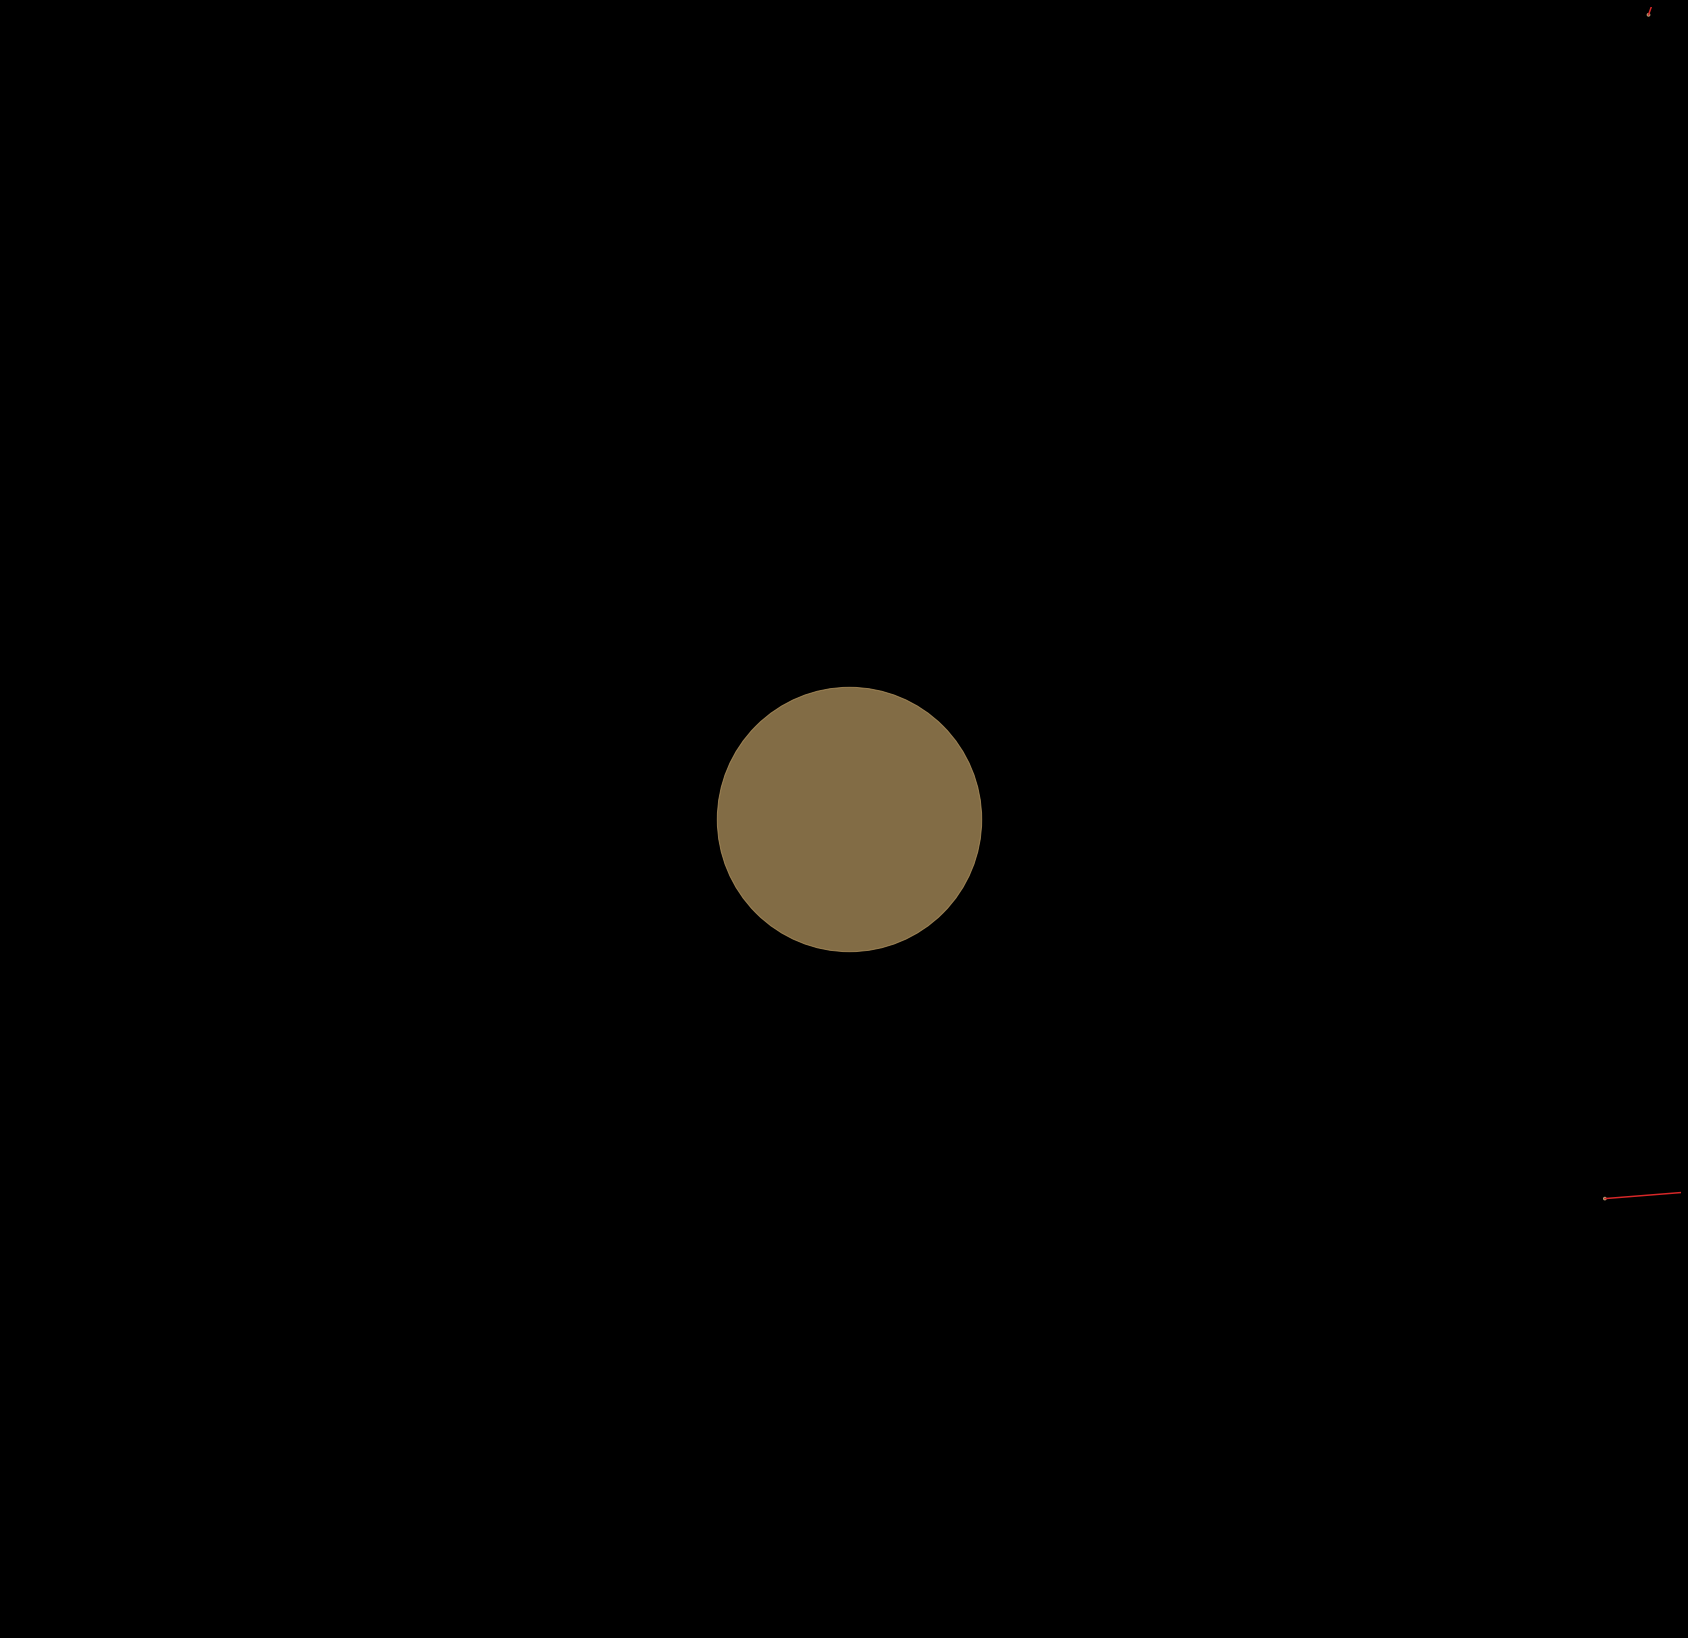

In [691]:
fig, axes = plt.subplots(figsize=(30, b/a*30), facecolor='black')
axes.set_facecolor('black')
axes.axis('off')

# burlywood
# silver
vel_scale = 1
for idx, v in enumerate(new_velocities):
    axes.plot([new_coordinates[idx,0], new_coordinates[idx,0] + vel_scale*v[0]],
              [new_coordinates[idx,1], new_coordinates[idx,1] + vel_scale*v[1]],
              color='tab:red')
axes.scatter(new_coordinates[1:,0], new_coordinates[1:,1],
             color='burlywood', s=geometries[1:,1], alpha=0.7)
axes.scatter(new_coordinates[0,0], new_coordinates[0,1],
             color=Planet_Colors[planet], s=geometries[0,1], alpha=0.7)

scale = 2.5
axes.set_xlim(-np.max(coordinates[:,0])*scale, np.max(coordinates[:,0])*scale)
axes.set_ylim(-np.max(coordinates[:,1])*scale, np.max(coordinates[:,1])*scale)

axes.set_xticks([])
axes.set_yticks([])

plt.show()

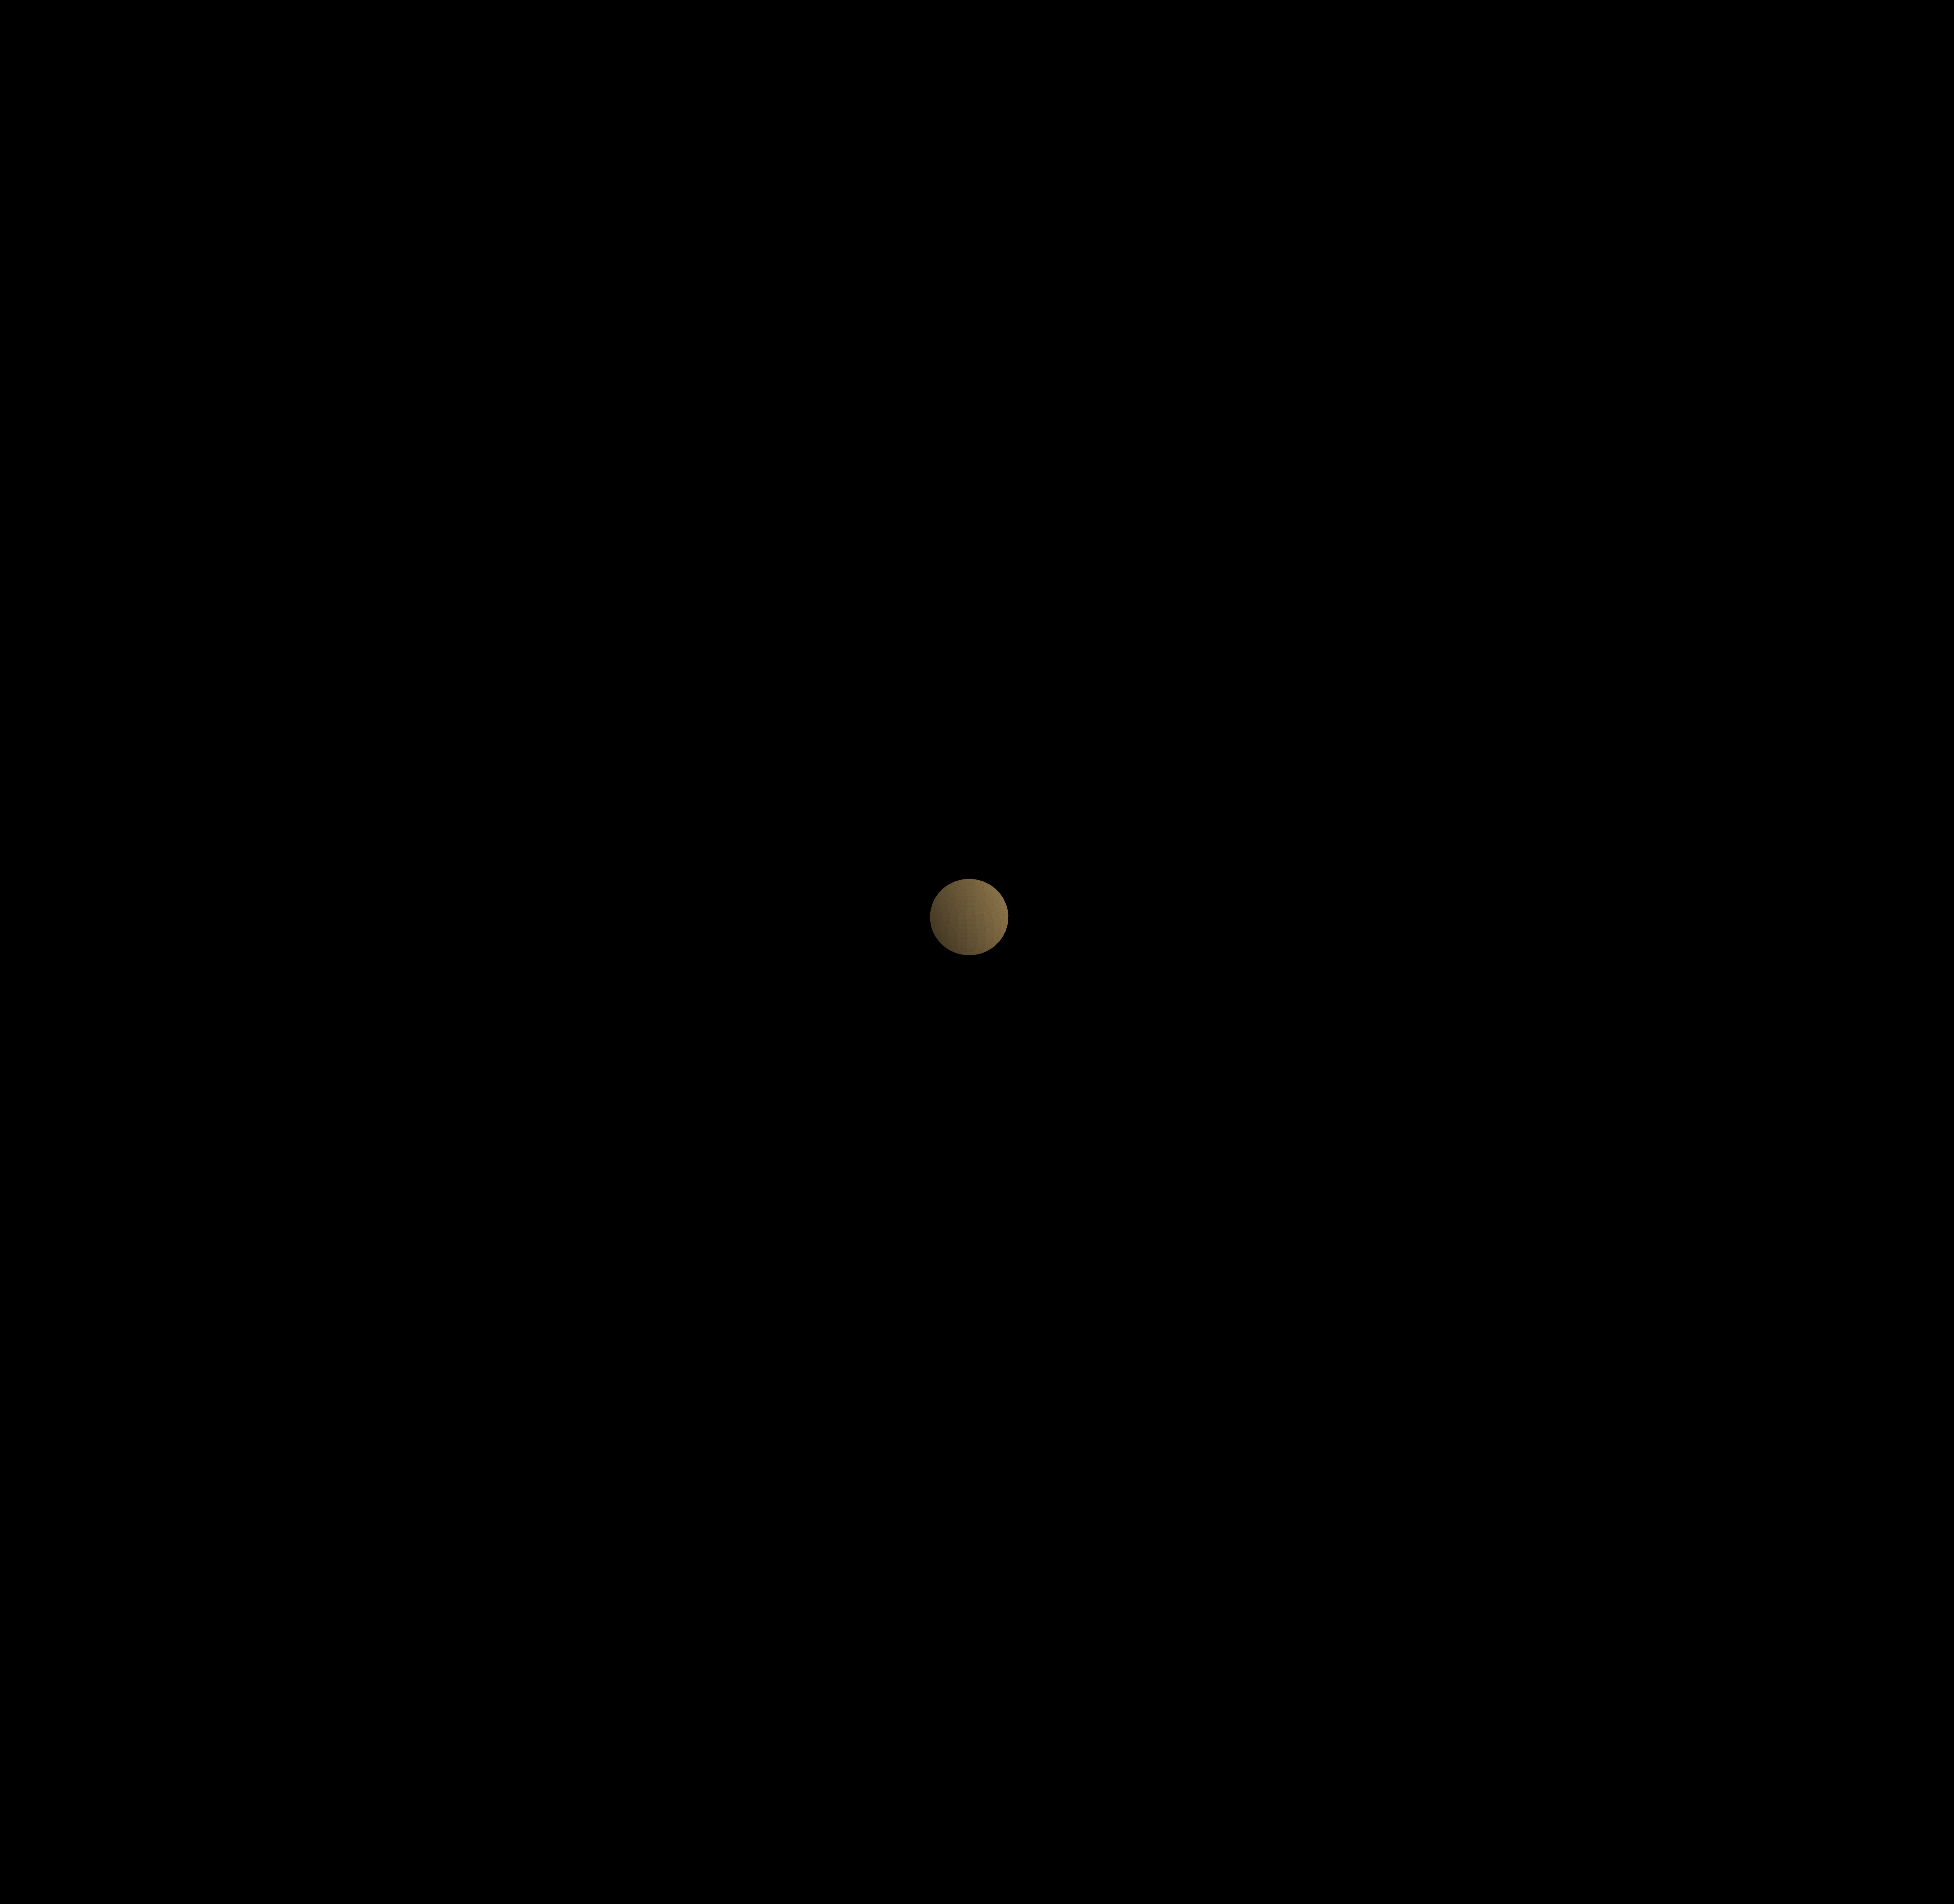

In [692]:
fig, ax = plt.subplots(figsize=(20,20), dpi=300, facecolor='black', subplot_kw={'projection' : '3d'})
#ax.set_aspect('equal')

azimuth = 120
elevation = 30
ax.view_init(elevation, azimuth)
ax.set_facecolor('black')
ax.axis('off')

scale = 1.2
ax.set_xlim3d(-a*scale, a*scale)
ax.set_ylim3d(-a*scale, a*scale)
ax.set_zlim3d(-a*scale, a*scale)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Plot planet
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = R * np.outer(np.cos(u), np.sin(v))
y = R * np.outer(np.sin(u), np.sin(v))
z = R * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x+c, y, z, rstride=4, cstride=4, color=Planet_Colors[planet], linewidth=0, alpha=0.5)

vel_scale = 1
for idx, v in enumerate(new_velocities):
    ax.plot([new_coordinates[idx,0], new_coordinates[idx,0]+vel_scale*v[0]],
            [new_coordinates[idx,1], new_coordinates[idx,1]+vel_scale*v[1]],
            color='tab:red')
ax.scatter(new_coordinates[1:,0], new_coordinates[1:,1],
            edgecolor=None, color='burlywood', s=geometries[1:,1], alpha=0.7)

plt.show()

## Mayavi high-quality models

#### Sources:
- https://docs.enthought.com/mayavi/mayavi/auto/example_tvtk_in_mayavi.html
- https://stackoverflow.com/questions/53074908/map-an-image-onto-a-sphere-and-plot-3d-trajectories
- https://www.solarsystemscope.com/textures/

In [329]:
os.listdir('./img_src/')

['ceres_fictional.jpg',
 'earth.jpg',
 'earth_blue.png',
 'earth_clouds.jpg',
 'earth_daymap.jpg',
 'earth_nightmap.jpg',
 'eris_fictional.jpg',
 'haumea_fictional.jpg',
 'jupiter.jpg',
 'makemake_fictional.jpg',
 'mars.jpg',
 'mercury.jpg',
 'moon.jpg',
 'moon2.jpg',
 'moon4k.jpg',
 'neptune.jpg',
 'saturn.jpg',
 'saturn_ring_alpha.png',
 'sun.jpg',
 'uranus.jpg',
 'venus_atmosphere.jpg',
 'venus_surface.jpg']

In [607]:
fig = mlab.figure(size=(800,b/a*800))

image_file = './img_src/{0}.jpg'.format(planet.lower())

# load and map the texture
img = tvtk.JPEGReader()
img.file_name = image_file
texture = tvtk.Texture(input_connection=img.output_port, interpolate=1)
# (interpolate for a less raster appearance when zoomed in)

# use a TexturedSphereSource, a.k.a. getting our hands dirty
Nrad = 180

# create the sphere source with a given radius and angular resolution
sphere = tvtk.TexturedSphereSource(radius=R, theta_resolution=Nrad,
                                   phi_resolution=Nrad)

# assemble rest of the pipeline, assign texture    
sphere_mapper = tvtk.PolyDataMapper(input_connection=sphere.output_port)
sphere_actor = tvtk.Actor(mapper=sphere_mapper, texture=texture)

asts1 = mlab.points3d(coordinates[1:,0], coordinates[1:,1], np.zeros((n_bodies)), geometries[1:,1],
                      colormap='copper', scale_factor=500)
asts2 = mlab.points3d(new_coordinates[1:,0], new_coordinates[1:,1], np.zeros((n_bodies)), geometries[1:,1],
                      colormap='Reds', scale_factor=500)

fig.scene.add_actor(sphere_actor)

display(fig)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x03\x1c\x08\x02\x00\x00\x00\'\xaaV\xe9\…